# ASL-Alphabet Classification

This small notebook contains approaches to classify letter/alphabet images that contain gestures of the American Sign Language (ASL). Deep Learning models are used with Keras, including CNNs defined from scratch, transfer learning with models pre-trained on ImageNet and autoencoders in combination with random forests.

The original dataset can be downloaded from Kaggle: [asl-alphabet](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). Download from [here](https://www.kaggle.com/datasets/grassknoted/asl-alphabet/download?datasetVersionNumber=1).

**See the co-located [`README.md`](README.md) file for more information and the preliminary conclusions.**

Table of Contents:

- [1. Load Dataset](#1.-Load-Dataset)
- [2. Visualize and Examine Dataset](#2.-Visualize-and-Examine-Dataset)
- [3. Pre-processing: One-Hot Encoding](#3.-Pre-processing:-One-Hot-Encoding)
- [4. Define Model 1: Simple CNN from Scratch](#4.-Define-Model-1:-Simple-CNN-from-Scratch)
- [5. Train Model 1](#5.-Train-Model-1)
- [6. Evaluate Model 1](#6.-Evaluate-Model-1)
- [7. Define, Train & Evaluate Model 2: ResNet50/VGG16 with Transfer Learning](#7.-Define,-Train-&-Evaluate-Model-2:-ResNet50/VGG16-with-Transfer-Learning)
- [8. Define, Train & Evaluate Model 3: Autoencoder + Random Forest](#8.-Define,-Train-&-Evaluate-Model-3:-Autoencoder-+-Random-Forest)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mxagar/asl_alphabet_image_classification/blob/main/asl_alphabet.ipynb)

## 1. Load Dataset

In [2]:
from google.colab import files

In [3]:
# From Desktop, upload: utils.py
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving utils.py to utils.py
User uploaded file "utils.py" with length 2751 bytes


In [ ]:
# GDrive: upload asl dataset downloaded from Kaggle (see link above)
# Mount GDrive to Colab folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Copy things to a local folder and unzip
!curl -L -o asl-alphabet.zip\
  https://www.kaggle.com/api/v1/datasets/download/grassknoted/asl-alphabet
!mkdir data
!unzip -q asl-alphabet.zip -d data/
!cp -r drive/MyDrive/Data/asl/* data/
!unzip -q data/asl_alphabet_train.zip -d data/
!unzip -q data/asl_alphabet_test.zip -d data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1049M  100 1049M    0     0   174M      0  0:00:06  0:00:06 --:--:--  227M
mkdir: cannot create directory ‘data’: File exists
cp: cannot stat 'drive/MyDrive/Data/asl/*': No such file or directory
replace data/asl_alphabet_train/real_loupe/20181002_124248_00000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace data/asl_alphabet_test/real_loupe/20181002_125539_00000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Flush and unmount; changes persist in Google Drive
drive.flush_and_unmount()

### (When data available, start from here)

In [8]:
import pickle
import numpy as np
np.random.seed(5)
import pandas as pd
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [11]:
# Load pre-shuffled training and test datasets
# Both the train & test splits are taken from the same dataset
(x_train, y_train), (x_test, y_test) = utils.load_data(
    container_path = 'data/asl_alphabet_train/asl_alphabet_train')

In [38]:
x_train.shape

(60000, 50, 50, 3)

In [39]:
y_train.shape

(60000,)

In [40]:
y_train

array([16, 19, 11, ...,  4, 21, 21])

In [41]:
x_test.shape

(15000, 50, 50, 3)

In [42]:
x_train.min()

np.float32(-247.36)

In [43]:
x_train.max()

np.float32(-206.878)

## 2. Visualize and Examine Dataset

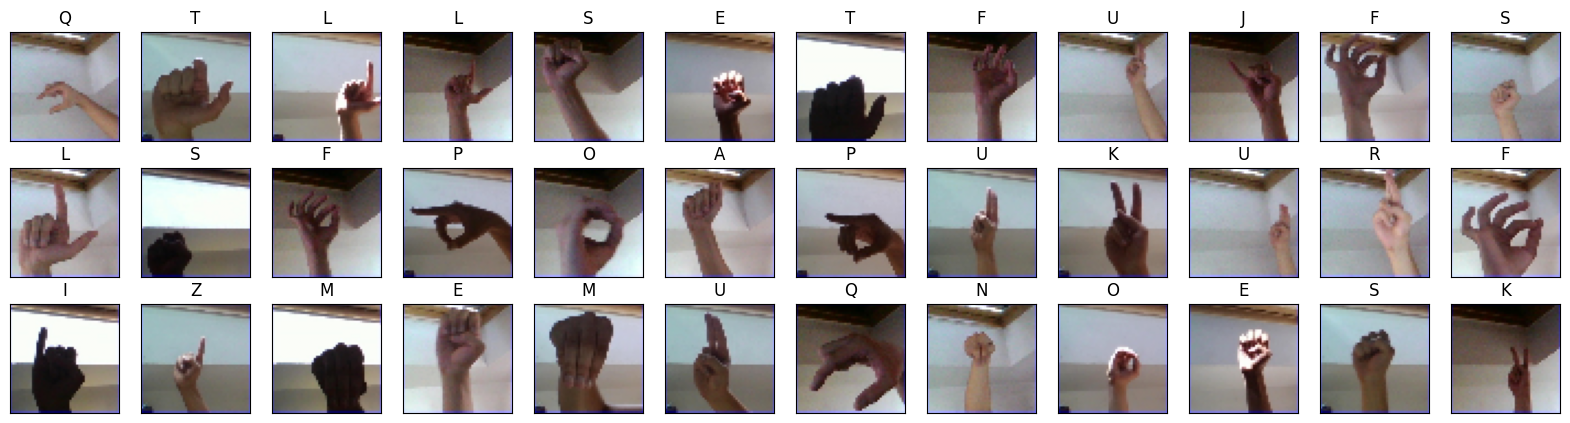

In [12]:
# Store labels of dataset
#labels = ['A', 'B', 'C']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
          'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
          'S', 'T', 'U', 'W', 'X', 'Y', 'Z']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

In [13]:
# The dataset is quite balanced!
print("Train/test samples per class:")
for i, label in enumerate(labels):
    num_train = sum(y_train==i)
    num_test = sum(y_test==i)
    print(f"{label}: {num_train} / {num_test} = {round(num_train/num_test, 2)}")

Train/test samples per class:
A: 2384 / 616 = 3.87
B: 2392 / 608 = 3.93
C: 2454 / 546 = 4.49
D: 2395 / 605 = 3.96
E: 2379 / 621 = 3.83
F: 2386 / 614 = 3.89
G: 2408 / 592 = 4.07
H: 2416 / 584 = 4.14
I: 2354 / 646 = 3.64
J: 2387 / 613 = 3.89
K: 2412 / 588 = 4.1
L: 2382 / 618 = 3.85
M: 2399 / 601 = 3.99
N: 2360 / 640 = 3.69
O: 2397 / 603 = 3.98
P: 2391 / 609 = 3.93
Q: 2409 / 591 = 4.08
R: 2398 / 602 = 3.98
S: 2396 / 604 = 3.97
T: 2418 / 582 = 4.15
U: 2436 / 564 = 4.32
W: 2429 / 571 = 4.25
X: 2410 / 590 = 4.08
Y: 2403 / 597 = 4.03
Z: 2405 / 595 = 4.04


## 3. Pre-processing: One-Hot Encoding

In [16]:
from keras.utils import to_categorical

# One-hot encode the training labels
y_train_OH =to_categorical(y_train, len(labels))

# One-hot encode the test labels
y_test_OH = to_categorical(y_test, len(labels))

## 4. Define Model 1: Simple CNN from Scratch

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [18]:
model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=16,
                 kernel_size=3,
                 padding='same',
                 activation='relu',
                 input_shape=(50, 50, 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) # 50/2 = 25
# Add a convolutional layer
model.add(Conv2D(filters=32,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) # 25/2 = 12
# Add a convolutional layer
model.add(Conv2D(filters=64,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) # 12/2 = 6
# Add a convolutional layer
model.add(Conv2D(filters=128,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) # 6/2 = 3
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))
# Summarize the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │        12,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,601 (2.67 MB)

 Trainable params: 700,601 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train Model 1

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
# Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# Early stopping when validation loss stops decreasing
# Arguments:
# - monitor: value to be monitored -> val_loss: loss of validaton data
# - mode: min -> training stops when monitored value stops decreasing
# - patience: number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [22]:
# Train the model
hist = model.fit(x_train,
                 y_train_OH,
                 epochs=20,
                 validation_split=0.2,
                 batch_size=32,
                 shuffle=True,
                 callbacks=[early_stop])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3460 - loss: 2.1133 - val_accuracy: 0.9452 - val_loss: 0.1740
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9223 - loss: 0.2279 - val_accuracy: 0.9703 - val_loss: 0.0788
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9709 - loss: 0.0881 - val_accuracy: 0.9887 - val_loss: 0.0342
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9814 - loss: 0.0589 - val_accuracy: 0.9924 - val_loss: 0.0219
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9878 - loss: 0.0416 - val_accuracy: 0.9993 - val_loss: 0.0031
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9887 - loss: 0.0358 - val_accuracy: 0.9973 - val_loss: 0.0070
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9905 - loss: 0.0343 - val_accuracy: 0.9954 - val_loss: 0.0147
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9914 - loss: 0.02

## 6. Evaluate Model 1

<Axes: >

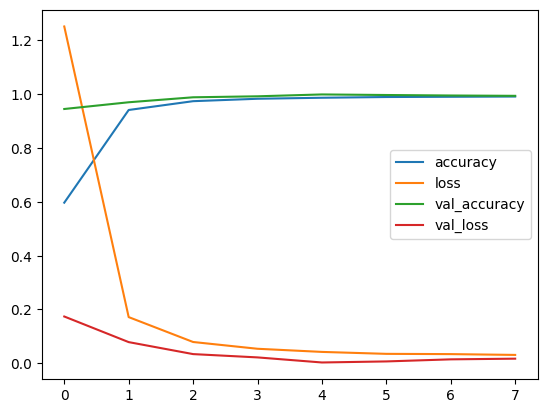

In [23]:
# Plot learning curves
losses = pd.DataFrame(model.history.history)
losses.plot()

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [25]:
# Obtain accuracy on test set
score = model.evaluate(x=x_test,
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9928666949272156


In [26]:
# Get predicted probabilities for test dataset
y_probs = model.predict(x_test)

# Get predicted labels for test dataset
#y_preds = model.predict_classes(x_test)
y_preds = np.argmax(y_probs, axis=1)

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [27]:
outcome = pd.DataFrame(np.array([y_test,y_preds]).T, columns=['true', 'pred'])
id2label = {i:value for i,value in enumerate(labels)}
outcome = outcome[['true','pred']].replace(id2label)

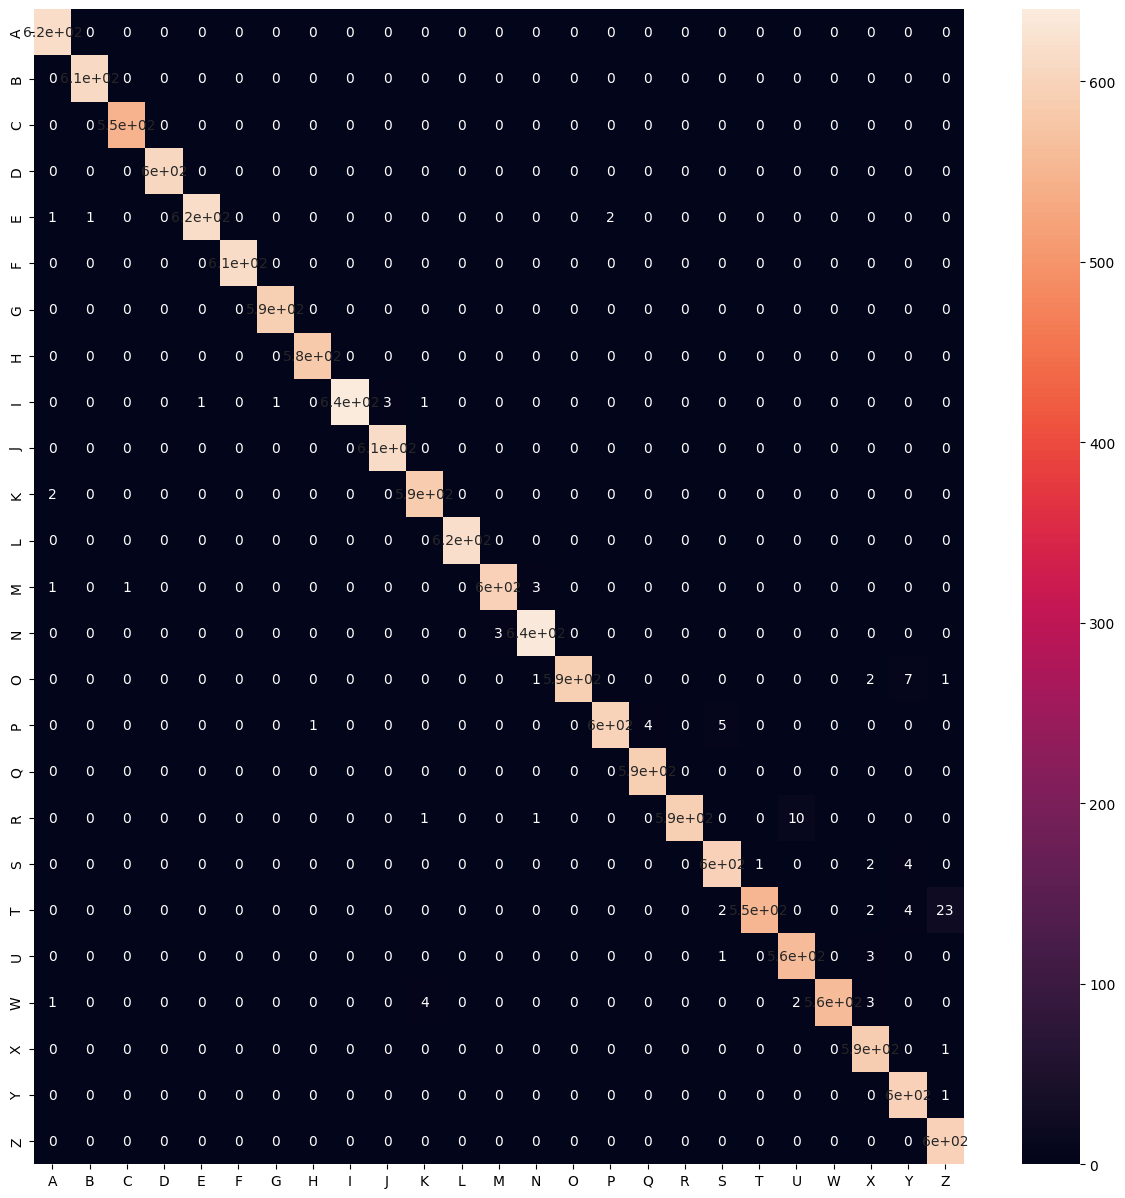

In [28]:
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(outcome['true'],outcome['pred']),
            xticklabels=labels,
            yticklabels=labels,
            annot=True);

In [29]:
# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

In [30]:
len(bad_test_idxs)

107

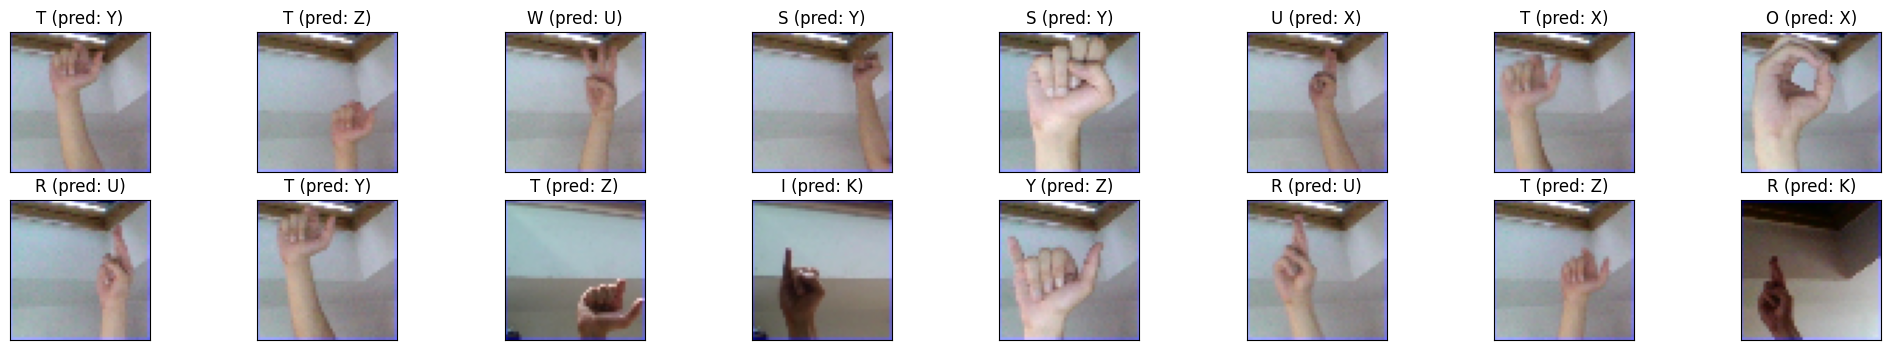

In [31]:
# Print a random subset of mislabeled examples
fig = plt.figure(figsize=(25,4))
subset_size = 16
try:
    assert subset_size < len(bad_test_idxs)
except AssertionError:
    print("Use a smaller subset size!")
# Pick a random subset
z = int(np.random.rand()*(len(bad_test_idxs)-subset_size))
subset = bad_test_idxs[z:(z+subset_size)]
for i, idx in enumerate(subset):
    ax = fig.add_subplot(2, int(np.ceil(len(subset)/2)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

## 7. Define, Train & Evaluate Model 2: ResNet50/VGG16 with Transfer Learning

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.3535 - loss: 2.2509 - val_accuracy: 0.6526 - val_loss: 1.1003
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.6310 - loss: 1.1630 - val_accuracy: 0.7753 - val_loss: 0.7386
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7208 - loss: 0.8711 - val_accuracy: 0.7630 - val_loss: 0.7345
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.7748 - loss: 0.6941 - val_accuracy: 0.8312 - val_loss: 0.5046
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.8109 - loss: 0.5773 - val_accuracy: 0.8632 - val_loss: 0.4094
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.8370 - loss: 0.4996 - val_accuracy: 0.8839 - val_loss: 0.3609
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.8586 - loss: 0.4284 - val_accuracy: 0.8852 - val_loss: 0.3287
Epoch 8/20
1500/1500 ━━━━

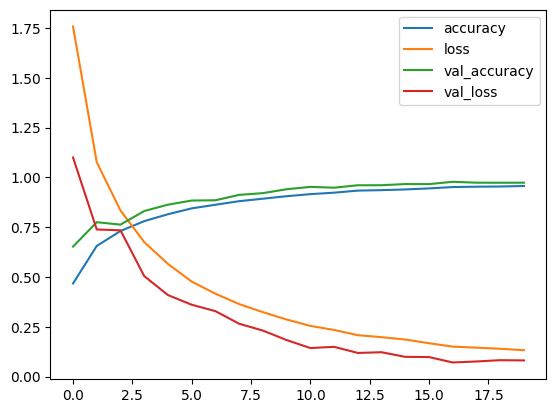

In [33]:
#7. Define, Train & Evaluate Model 2: ResNet50 with Transfer Learning

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Apply ResNet50-specific preprocessing if needed (remove this if already normalized manually)
x_train_trans = preprocess_input(x_train)
x_test_trans = preprocess_input(x_test)

# Build the model
transfer_model = Sequential()
pretrained_model = ResNet50(include_top=False,
                            input_shape=x_train.shape[1:],
                            pooling='avg',
                            weights='imagenet')

# Freeze all layers except the last few for fine-tuning
for layer in pretrained_model.layers[:-10]:
    layer.trainable = False
for layer in pretrained_model.layers[-10:]:
    layer.trainable = True

transfer_model.add(pretrained_model)

# Add custom classifier layers
transfer_model.add(Flatten())
transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(len(labels), activation='softmax'))

# Compile the model
transfer_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# Train the model
history = transfer_model.fit(
    x_train_trans, y_train_OH,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop]
)

# Plot training history
losses = pd.DataFrame(transfer_model.history.history)
losses.plot()

# Evaluate the model on the test set
score = transfer_model.evaluate(x=x_test_trans, y=y_test_OH, verbose=0)
print('Test accuracy:', score[1])


In [34]:
# Apply ResNet50-specific preprocessing
def preprocess(images, labels):
    return preprocess_input(images), labels

x_train_trans, y_train_OH = preprocess(x_train, y_train_OH)
x_test_trans, y_test_OH = preprocess(x_test, y_test_OH)

In [35]:
x_train_trans.min()

np.float32(-247.36)

In [36]:
x_train_trans.max()

np.float32(-206.878)

In [37]:
x_train_trans.shape

(60000, 50, 50, 3)

In [45]:
# Empty sequential model
from tensorflow.keras.applications import VGG16
transfer_model = Sequential()

# From Keras Applications, we can download many pre-trained models
# If we specify include_top=False, the original input/output layers
# are not imported.
# Note that we can specify our desired the input and output layer sizes!
pretrained_model= VGG16(include_top=False,
                   input_shape=(x_train.shape[1:]),
                   pooling='avg',
                   classes=len(labels),
                   weights='imagenet')
# Freeze layers; if not active, fine-tuning, else transfer learning
for layer in pretrained_model.layers:
    layer.trainable = False

# Add ResNet to empty sequential model
transfer_model.add(pretrained_model)

# Now, add the last layers of our model which map the extracted features
# too the classes - that's the classifier, what's really trained
transfer_model.add(Flatten())
transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(len(labels), activation='softmax'))

# The complete model (fine-tuning) has 24/0.7 = 34x more parameters than the previous one!
# The transfer learning model has 1/0.7 = 1.4x more parameters than the previous one
transfer_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │        12,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,990,169 (57.18 MB)

 Trainable params: 275,481 (1.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping when validation loss stops decreasing
# Arguments:
# - monitor: value to be monitored -> val_loss: loss of validaton data
# - mode: min -> training stops when monitored value stops decreasing
# - patience: number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [47]:
from tensorflow.keras.optimizers import Adam

# Compile
#resnet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
transfer_model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

# Train/Fit
# I use less epochs, since in the previous model with 10 we were already good enough
history = transfer_model.fit(
                 x_train_trans,
                 #x_train,
                 y_train_OH,
                 epochs=20,
                 validation_split=0.2,
                 batch_size=32,
                 shuffle=True,
                 callbacks=[early_stop])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.0384 - loss: 4.5743 - val_accuracy: 0.0358 - val_loss: 3.2191
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.0419 - loss: 3.2191 - val_accuracy: 0.0455 - val_loss: 3.2164
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.0423 - loss: 3.2179 - val_accuracy: 0.0452 - val_loss: 3.2149
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.0434 - loss: 3.2158 - val_accuracy: 0.0450 - val_loss: 3.2137
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.0413 - loss: 3.2147 - val_accuracy: 0.0462 - val_loss: 3.2116
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.0443 - loss: 3.2151 - val_accuracy: 0.0437 - val_loss: 3.2131
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.0451 - loss: 3.2140 - val_accuracy: 0.0459 - val_loss: 3.2107
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.0414 -

<Axes: >

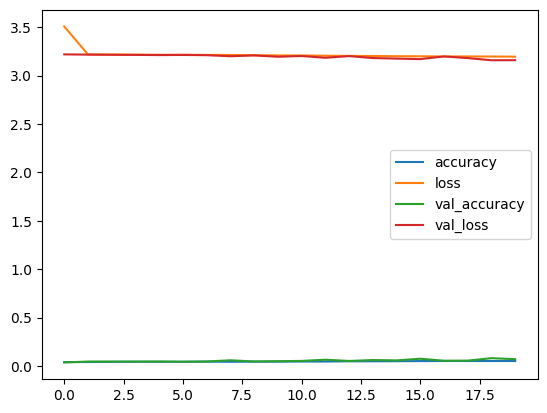

In [48]:
# Plot learning curves
losses = pd.DataFrame(transfer_model.history.history)
losses.plot()

In [49]:
# Obtain accuracy on test set
score = transfer_model.evaluate(x=x_test_trans,
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.06286666542291641


In [50]:
# Get predicted probabilities for test dataset
y_probs = transfer_model.predict(x_test_trans)

# Get predicted labels for test dataset
#y_preds = transfer_model.predict_classes(x_test_trans)
y_preds = np.argmax(y_probs, axis=1)

469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step


In [51]:
outcome = pd.DataFrame(np.array([y_test,y_preds]).T, columns=['true', 'pred'])
id2label = {i:value for i,value in enumerate(labels)}
outcome = outcome[['true','pred']].replace(id2label)

In [52]:
#from sklearn.metrics import confusion_matrix
#import seaborn as sns

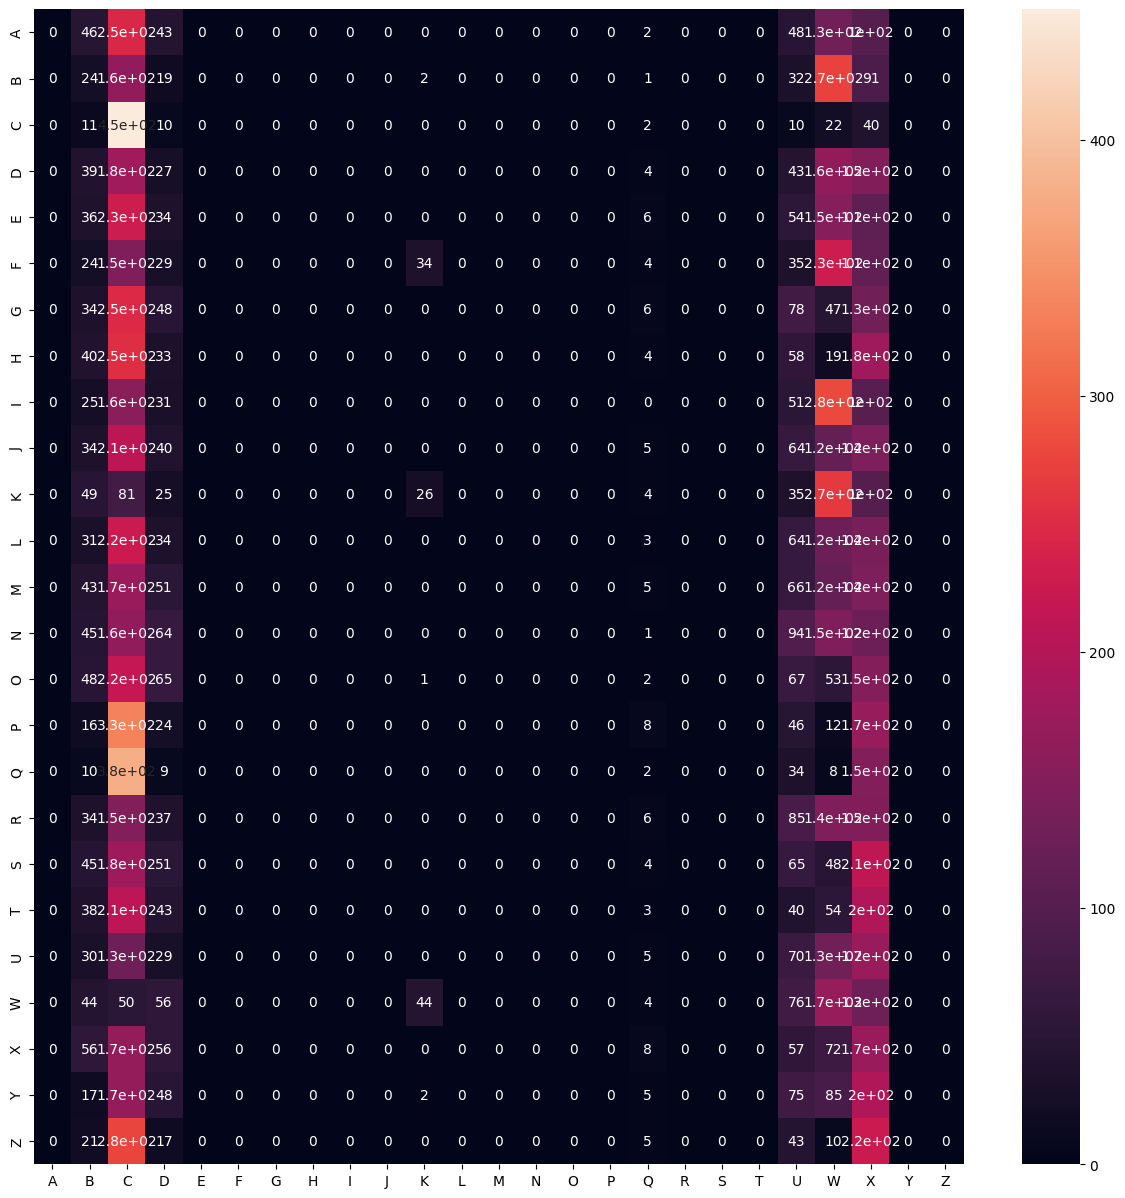

In [53]:
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(outcome['true'],outcome['pred']),
            xticklabels=labels,
            yticklabels=labels,
            annot=True);

In [54]:
# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

In [55]:
len(bad_test_idxs)

14057

## 8. Define, Train & Evaluate Model 3: Autoencoder + Random Forest

This model is probably a little bit peculiar. Since the neural networks seem to be working that well, I will try to use them to compress the images to a latent representation. Then, with that latent representation:

- I attach a classifier: a Random Forest.
- I plot the samples in a 2D space with manifold learning.

In [56]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [57]:
# Encoder: we compress the image
encoder = Sequential()
# First convolutional layer accepts image input
encoder.add(Conv2D(filters=32,
                 kernel_size=3,
                 padding='same',
                 activation='relu',
                 input_shape=(50, 50, 3)))
# Add a max pooling layer
encoder.add(MaxPooling2D(pool_size=(2, 2))) # 50/2 = 25
# Add a convolutional layer
encoder.add(Conv2D(filters=64,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
encoder.add(MaxPooling2D(pool_size=(2, 2))) # 25/2 = 12
# Add a convolutional layer
encoder.add(Conv2D(filters=128,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
encoder.add(MaxPooling2D(pool_size=(2, 2))) # 12/2 = 6
# Add a convolutional layer
encoder.add(Conv2D(filters=256,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
encoder.add(MaxPooling2D(pool_size=(2, 2))) # 6/2 = 3
# Compressed size: (batch, 3, 3, 256): 2304
# This flattening is not really necessary...
encoder.add(Flatten()) # (batch, 2304)
encoder.add(Dense(512)) # 2304 -> 512
encoder.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,180,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,568,576 (5.98 MB)

 Trainable params: 1,568,576 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Decoder: we expand the compressed representation
decoder = Sequential()
decoder.add(Dense(2304, input_shape=[512])) # 512 -> 2304
# Reshape: un-flatten the compressed representation
#decoder.add(Reshape([3, 3, 128], input_shape=[1152]))
decoder.add(Reshape([3, 3, 256]))
# (3, 3, 128) -> (6, 6, 64)
# W_out = ((W_in - 1) * strides[0] + kernel_size[0] - 2 * padding[0] + output_padding[0])
# W_out = (12-1)*2 + 3 - 2*P + OP
decoder.add(Conv2DTranspose(filters=128,
                              kernel_size=2,
                              strides=2,
                              padding="same",
                              activation="relu"))
# (6, 6, 64) -> (12, 12, 32)
decoder.add(Conv2DTranspose(filters=64,
                              kernel_size=2,
                              strides=2,
                              padding="same",
                              activation="relu"))
# (12, 12, 32) -> (25, 25, 16)
decoder.add(Conv2DTranspose(filters=32,
                              kernel_size=3,
                              strides=2,
                              padding="valid",
                              activation="relu"))
# (25, 25, 16) -> (50, 50, 3)
decoder.add(Conv2DTranspose(filters=3,
                              kernel_size=2,
                              strides=2,
                              padding="same",
                              activation="relu"))

decoder.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 2304)           │     1,181,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 6, 6, 128)      │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 12, 12, 64)     │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 25, 25, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 50, 50, 3)      │           387 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,364,835 (5.21 MB)

 Trainable params: 1,364,835 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Autoencoder
autoencoder = Sequential([encoder,decoder])

autoencoder.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 512)            │     1,568,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 50, 50, 3)      │     1,364,835 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,933,411 (11.19 MB)

 Trainable params: 2,933,411 (11.19 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping when validation loss stops decreasing
# Arguments:
# - monitor: value to be monitored -> val_loss: loss of validaton data
# - mode: min -> training stops when monitored value stops decreasing
# - patience: number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [61]:
# We use the BINARY cross-entropy loss
# because we want to know whether the input and output images are equivalent
autoencoder.compile(loss='binary_crossentropy', # mse
                   optimizer='rmsprop')

In [62]:
# Train
autoencoder.fit(x_train,
                x_train,
                epochs=20,
                validation_split=0.2,
                batch_size=32,
                shuffle=True,
                callbacks=[early_stop])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: -3488.9287 - val_loss: -3691.2444
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: -3691.2529 - val_loss: -3691.2444
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: -3691.2673 - val_loss: -3691.2444
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: -3691.2559 - val_loss: -3691.2444
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: -3691.2483 - val_loss: -3691.2444
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: -3691.2646 - val_loss: -3691.2444
Epoch 6: early stopping


<Axes: >

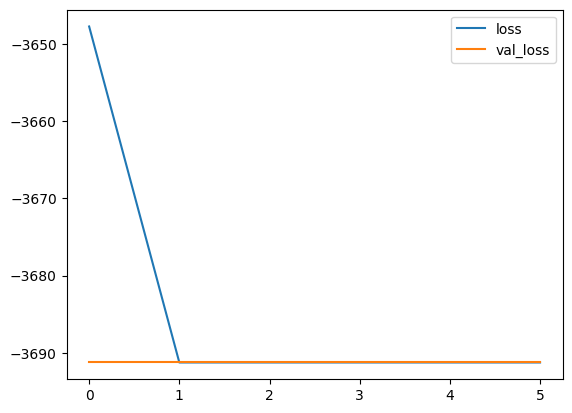

In [63]:
# Plot learning curves
losses = pd.DataFrame(autoencoder.history.history)
losses.plot()

In [64]:
x_test_enc_0 = encoder.predict(np.expand_dims(x_test[0], axis=0))
print(x_test_enc_0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
[[  3.2962067    7.401405   -10.641623   -11.572739   -19.229334
   23.55065      4.758371   -22.359531   -12.235472    24.574032
  -10.128239   -44.987938    22.209673    -7.7298055  -18.958868
  -17.31498     -5.392086    -9.262306   -15.626069    29.789347
   17.09147    -13.859332    22.704124     0.34022102   6.988804
   -0.26842448 -16.416517    19.754694    27.81148      5.717146
   -8.030097     4.424542    -1.8490101  -15.349978    17.879889
   11.984014    36.719387   -21.342829    20.689196   -30.888918
    6.1474566   -6.815738     3.4535117  -23.820383     3.2850063
   -0.3690631    4.0091224   10.158117     3.7583594   -5.8070426
  -21.146822   -20.858189     4.0185413  -12.986885     3.6882243
   -0.57446605   6.4867883    1.9024682  -34.18946     -2.1829507
    7.3407493   14.693942   -16.466543    20.056093    19.783754
  -20.406488    22.801992    10.628482    -8.6556225   29.130209
  -23.004917   -14.063113    -3.1848888    5.36

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


Text(0.5, 1.0, 'Reconstructed')

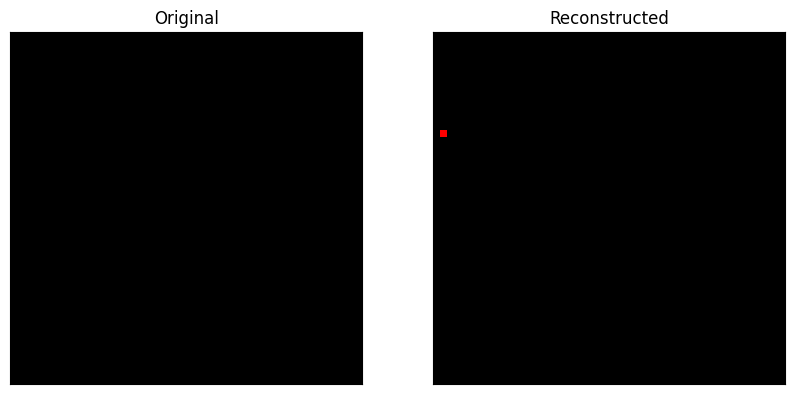

In [65]:
x_org = x_test[2]
x_test_rec = autoencoder.predict(np.expand_dims(x_org, axis=0))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(np.squeeze(x_org))
ax1.set_title("Original")
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.imshow(np.squeeze(x_test_rec[0]))
ax1.set_title("Reconstructed")

In [66]:
x_train_enc = encoder.predict(x_train)
x_test_enc = encoder.predict(x_test)
print(x_train_enc.shape)
print(x_test_enc.shape)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
(60000, 512)
(15000, 512)


In [67]:
print(x_train_enc.shape)
print(x_test_enc.shape)
data_dict = {
    "x_train_enc": x_train_enc,
    "x_test_enc": x_test_enc,
    "y_train_OH": y_train_OH,
    "y_train": y_train,
    "y_test_OH": y_test_OH,
    "y_test": y_test,
    "labels": labels
}

(60000, 512)
(15000, 512)


In [68]:
#import pickle
pickle.dump(data_dict, open('data_dict.pkl','wb')) # wb: write bytes

In [71]:
data_dict = pickle.load(open('data_dict.pkl','rb')) # rb: read bytes
x_train_enc = data_dict["x_train_enc"]
x_test_enc = data_dict["x_test_enc"]
y_train_OH = data_dict["y_train_OH"]
y_train = data_dict["y_train"]
y_test_OH = data_dict["y_test_OH"]
y_test = data_dict["y_test"]
labels = data_dict["labels"]

In [69]:
# Scale (for the logistic regression)
from sklearn.preprocessing import StandardScaler

scaler_enc = StandardScaler()
x_train_enc_scaled = scaler_enc.fit_transform(x_train_enc)
x_test_enc_scaled = scaler_enc.transform(x_test_enc)

In [70]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params_grid_rf = {
  'max_depth': [10, 25],
  'n_estimators': [100, 150]
  #'min_samples_split': [5, 10]
}
params_grid_lr = {
  'penalty': ['l1', 'l2'],
  #'C': [0.01, 0.1, 1.0, 10]
  'C': [0.1, 1.0]
}

rfc = RandomForestClassifier(random_state=42,
                             max_depth=10,
                             n_jobs=-1,
                             n_estimators=100)
logr = LogisticRegression(random_state=42,
                          solver='saga',
                          multi_class='ovr',
                          n_jobs=-1)
# Notes on the scoring (look also at online docu):
# - can be a string or a callable; accuracy is in general bad, prefer others: 'f1', 'roc_auc'
# - if multi-class, there are one-versus-rest versions, e.g. 'roc_auc_ovr'
search = GridSearchCV(estimator = rfc, #logr, #rfc,
                       param_grid = params_grid_rf, #params_grid_lr, #params_grid_rf,
                       scoring='accuracy',
                       cv = 3, verbose = 10)

In [72]:
#x_train_enc_scaled
#y_train

In [73]:
#rfc.fit(x_train_enc_scaled, y_train)

In [74]:
search.fit(x_train_enc_scaled, y_train)
search_best = search.best_estimator_

print(search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START max_depth=10, n_estimators=100..............................
[CV 1/3; 1/4] END max_depth=10, n_estimators=100;, score=0.831 total time= 1.2min
[CV 2/3; 1/4] START max_depth=10, n_estimators=100..............................
[CV 2/3; 1/4] END max_depth=10, n_estimators=100;, score=0.830 total time= 1.2min
[CV 3/3; 1/4] START max_depth=10, n_estimators=100..............................
[CV 3/3; 1/4] END max_depth=10, n_estimators=100;, score=0.832 total time= 1.2min
[CV 1/3; 2/4] START max_depth=10, n_estimators=150..............................
[CV 1/3; 2/4] END max_depth=10, n_estimators=150;, score=0.836 total time= 1.8min
[CV 2/3; 2/4] START max_depth=10, n_estimators=150..............................
[CV 2/3; 2/4] END max_depth=10, n_estimators=150;, score=0.834 total time= 1.8min
[CV 3/3; 2/4] START max_depth=10, n_estimators=150..............................
[CV 3/3; 2/4] END max_depth=10, n_estimators

In [75]:
# Get predicted probabilities for test dataset
y_probs = search_best.predict_proba(x_test_enc_scaled)

# Get predicted labels for test dataset
y_preds = search_best.predict(x_test_enc_scaled)
#y_preds = np.argmax(yp, axis=1)

In [76]:
y_preds.shape

(15000,)

In [77]:
y_preds

array([ 2,  7, 13, ...,  1, 18, 16])

In [78]:
outcome = pd.DataFrame(np.array([y_test,y_preds]).T, columns=['true', 'pred'])
id2label = {i:value for i,value in enumerate(labels)}
outcome = outcome[['true','pred']].replace(id2label)

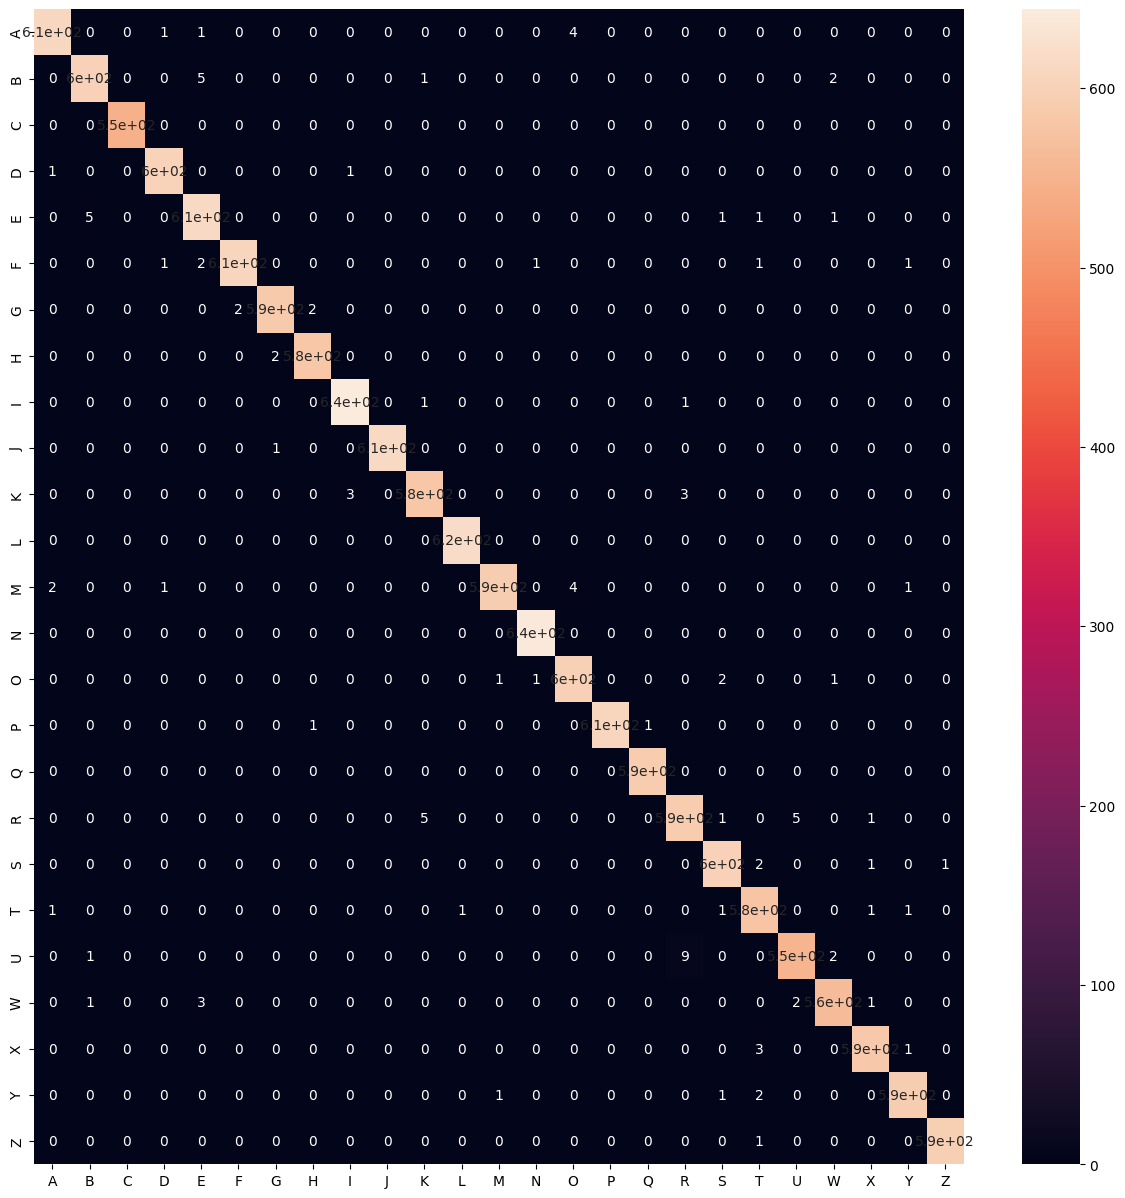

In [79]:
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(outcome['true'],outcome['pred']),
            xticklabels=labels,
            yticklabels=labels,
            annot=True);

In [80]:
# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

In [81]:
len(bad_test_idxs)

109

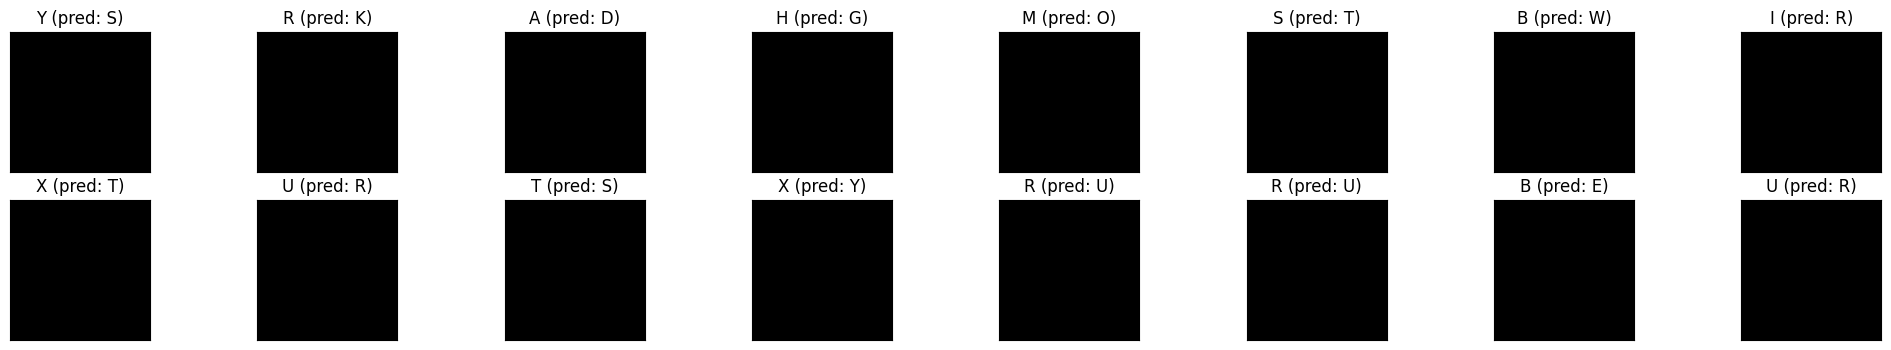

In [82]:
# Print a random subset of mislabeled examples
fig = plt.figure(figsize=(25,4))
subset_size = 16
try:
    assert subset_size < len(bad_test_idxs)
except AssertionError:
    print("Use a smaller subset size!")
# Pick a random subset
z = int(np.random.rand()*(len(bad_test_idxs)-subset_size))
subset = bad_test_idxs[z:(z+subset_size)]
for i, idx in enumerate(subset):
    ax = fig.add_subplot(2, int(np.ceil(len(subset)/2)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))